In [1]:
### Initial imports

import datetime
import io
import logging

import dateutil
import datetime
import numpy as np
import pandas as pd
import pymc3 as pm
import theano
import theano.tensor as T

logging.basicConfig(level=logging.INFO)
log = logging.getLogger(__name__)

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [3]:
### Import epimodel and load relevant files

from epimodel import RegionDataset, read_csv

rds = RegionDataset.load('../data/regions.csv')
csse = read_csv('../data/CSSE.csv')
#cms = read_csv("../data/CMS-binary.csv")
cms = read_csv("../data/CMS-0to1.csv")
print(f"CMS columns: {cms.columns!r}")

[2020-04-06 13:26:11,583] INFO(epimodel.regions): Name index has 6 potential conflicts: ['american samoa', 'georgia', 'guam', 'northern mariana islands', 'puerto rico', 'united states minor outlying islands']


CMS columns: Index(['Gatherings limited to', 'Business suspended',
       'Schools and universities closed', 'General curfew',
       'Public information', 'Healthcare specialisation', 'Public hygiene'],
      dtype='object')


In [5]:
### Parameters and data loading

CSSEColumn = "Confirmed"

# Days
Ds = pd.date_range(start='2020-02-10', end='2020-04-01', tz='utc')
nDs = len(Ds)

# Countermeasures

# CMS-01 columns
CMs = ['Gatherings limited to', 'Business suspended',
   'Schools and universities closed', 'General curfew',
   'Public information', 'Healthcare specialisation', 'Public hygiene']
# Selected CMS-b columns
#CMs = ["Contact isolation", "Some businesses suspended", "Many businesses suspended",
#       "Schools and universities closed", "Social distancing advised", "Gatherings limited to 10 or less",
#       "General curfew", "General strict isolation"]
nCMs = len(CMs)

# Countries (or just any regions)
Cs0 = ["BG", "UA", "PT", "IS", "RO", "HU", "IT", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "HU", "NO", "RO", "SE", "SI", "SK"]
Cs0 = ["PT", "IS", "HU", "HR", "BE", "NL", "DK", "DE", "AT", "CZ", "GE", "FR", "ES", "GB", "PL", "GR", "CH", "BE", "FI", "NO", "SE", "SI", "SK"]
Cs = []
# Filtering just countries with CSSE data, countermeasures data and at least MinConfirmed cases
for cc in set(Cs0):
    c = rds[cc]
    if c.Level == "country":
        if c.Code in csse.index and c.Code in cms.index:
            if csse.loc[(c.Code, Ds[-1]), CSSEColumn] > 100:
                Cs.append(c.Code)
nCs = len(Cs)
print(Cs)

# Probability of being in Confirmed cases X days after transmission, from 0
# Generated from Poisson dist., must sum to 1.0
DelayProb = np.array([0.00, 0.01, 0.02, 0.06, 0.10, 0.13, 0.15, 0.15, 0.13, 0.10, 0.07, 0.05, 0.03])
print(f"Delayprob sum={DelayProb.sum()}, E[DP]={np.sum(DelayProb*np.arange(len(DelayProb)))}")

# Active countermeasures per day and region
print("\nCountermeasures                            min   .. mean  .. max")
sd = cms.loc[Cs, CMs]
for cm in CMs:
    print(f"{cm:42} {sd[cm].min().min():.3f} .. {sd[cm].mean().mean():.3f} .. {sd[cm].max().max():.3f}")
ActiveCMs = np.stack([sd.loc[c].loc[Ds].T for c in Cs])
assert ActiveCMs.shape == (nCs, nCMs, nDs)
# [country, CM, day] Which CMs are active, and to what extent
ActiveCMs = ActiveCMs.astype(theano.config.floatX)

# Confirmed cases, masking values smaller than 10
Confirmed = csse[CSSEColumn].loc[(tuple(Cs), Ds)].unstack(1).values
assert Confirmed.shape == (nCs, nDs)
Confirmed[Confirmed < 10.0] = np.nan
# [country, day]
Confirmed = np.ma.masked_invalid(Confirmed.astype(theano.config.floatX))

CMDelayCut = 10
DGRMask = np.ones((nCs, nDs))
DGRMask[:, :10] = np.nan
DGRMask = np.ma.masked_invalid(DGRMask.astype(theano.config.floatX))


['FI', 'GE', 'HR', 'SK', 'GB', 'AT', 'GR', 'DE', 'FR', 'SE', 'IS', 'PT', 'DK', 'ES', 'PL', 'SI', 'BE', 'NL', 'CH', 'HU', 'CZ', 'NO']
Delayprob sum=1.0, E[DP]=6.78

Countermeasures                            min   .. mean  .. max
Gatherings limited to                      0.000 .. 0.150 .. 0.980
Business suspended                         0.000 .. 0.269 .. 1.000
Schools and universities closed            0.000 .. 0.356 .. 1.000
General curfew                             0.000 .. 0.164 .. 1.000
Public information                         0.000 .. 0.014 .. 0.250
Healthcare specialisation                  0.000 .. 0.020 .. 0.429
Public hygiene                             0.000 .. 0.005 .. 0.167


In [6]:
with pm.Model() as model:
    # [] Baseline growth rate (wide prior OK, mean estimates ~10% daily growth)
    BaseGrowthRate = pm.Lognormal("BaseGrowthRate", np.log(1.2), 2.0)
    
    # [country] Initial size of epidemic (the day before the start, only those detected; wide prior OK)
    InitialSize = pm.Lognormal("InitialSize", 0.0, 10, shape=(nCs,))
    
    # [country] Country growth rate
    # TODO: Estimate growth rate variance
    CountryGrowthRate = pm.Lognormal("CountryGrowthRate", pm.math.log(BaseGrowthRate), 0.3, shape=(nCs,))
    
    # [CM] How much countermeasures reduce growth rate
    # TODO: Possibly use another distribution
    CMReduction = pm.Lognormal("CMReduction", 0.0, 0.1, shape=(nCMs,))
    
    # [country, CM, day] Reduction factor for each CM,C,D
    ActiveCMReduction = T.reshape(CMReduction, (1, nCMs, 1)) ** ActiveCMs
    
    # [country, day] Reduction factor from CMs for each C,D (noise added below)
    GrowthReduction = pm.Deterministic("GrowthReduction", T.prod(ActiveCMReduction, axis=1))
    # Convolution of GrowthReduction by DelayProb
    DelayedGrowthReduction = None
    for i, dp in enumerate(DelayProb):
        if i == 0:
            DelayedGrowthReduction = dp * GrowthReduction
        else:
            shifted = T.concatenate((np.zeros((nCs, i)), GrowthReduction[:, :-i]), axis=1)
            shifted = GrowthReduction
            DelayedGrowthReduction = DelayedGrowthReduction + dp * shifted

    # Erase early DlayedGrowthRates in first ~10 days (would assume them non-present otherwise!)
    DelayedGrowthReduction = DelayedGrowthReduction[:, CMDelayCut:]
    
    # [country, day] The ideal predicted daily growth
    PreictedGrowth = pm.Deterministic("PredictedGrowth", T.reshape(CountryGrowthRate, (nCs, 1)) * DelayedGrowthReduction)
    
    # [country, day] The actual (still hidden) growth each day
    # TODO: Estimate noise varince (should be small, measurement variance below)
    #       Miscalibration: too low: time effects pushed into CMs, too high: explains away CMs
    DailyGrowth =  pm.Lognormal("DailyGrowth", pm.math.log(PreictedGrowth), 0.1, shape=(nCs, nDs - CMDelayCut))

    # Below I assume plain exponentia growth of confirmed rather than e.g. depending on the remaining
    # susceptible opulation etc. (Would be needed in later stages, though)

    # [country, day] The number of cases that would be detected with noiseless testing
    # (Noise source includes both false-P/N rates and local variance in test volume and targetting)
    # (Since we ony care about growth rates and assume consistent testing, it is fine to ignore real size)
    Size = pm.Deterministic("Size", T.reshape(InitialSize, (nCs, 1)) * DailyGrowth.cumprod(axis=1))
    # [country, day] Cummulative tested positives
    Observed = pm.Lognormal("Observed", pm.math.log(Size), 0.4, shape=(nCs, nDs - CMDelayCut), observed=Confirmed[:, CMDelayCut:])


/home/gavento/proj/.venv/lib/python3.7/site-packages/pymc3/model.py:1430: ImputationWarning:

Data in Observed contains missing values and will be automatically imputed from the sampling distribution.



In [7]:
print(model.check_test_point())
with model:
    trace = pm.sample(1000, chains=2, cores=2, init='adapt_diag')

[2020-04-06 13:26:59,774] INFO(pymc3): Auto-assigning NUTS sampler...
[2020-04-06 13:26:59,775] INFO(pymc3): Initializing NUTS using adapt_diag...


BaseGrowthRate_log__          -1.61
InitialSize_log__            -70.87
CountryGrowthRate_log__        6.27
CMReduction_log__              9.69
DailyGrowth_log__           1278.49
Observed_missing               0.00
Observed                  -13434.32
Name: Log-probability of test_point, dtype: float64


[2020-04-06 13:27:11,755] INFO(pymc3): Multiprocess sampling (2 chains in 2 jobs)
[2020-04-06 13:27:11,756] INFO(pymc3): NUTS: [Observed_missing, DailyGrowth, CMReduction, CountryGrowthRate, InitialSize, BaseGrowthRate]
Sampling 2 chains, 65 divergences: 100%|██████████| 3000/3000 [03:11<00:00, 15.66draws/s]
[2020-04-06 13:30:31,053] ERROR(pymc3): There were 44 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-04-06 13:30:31,054] ERROR(pymc3): There were 21 divergences after tuning. Increase `target_accept` or reparameterize.
[2020-04-06 13:30:31,055] ERROR(pymc3): The estimated number of effective samples is smaller than 200 for some parameters.


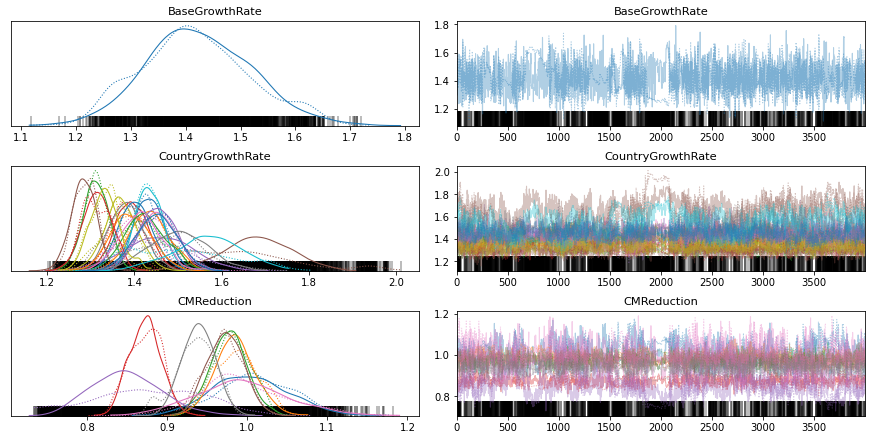

In [57]:
_ = pm.traceplot(trace, var_names=["BaseGrowthRate", "CountryGrowthRate", "CMReduction"])

0: Contact isolation
1: Some businesses suspended
2: Many businesses suspended
3: Schools and universities closed
4: Social distancing advised
5: Gatherings limited to 10 or less
6: General curfew
7: General strict isolation


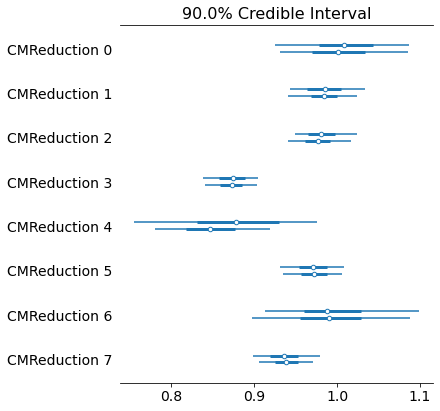

In [58]:
pm.forestplot(trace, var_names=['CMReduction'], credible_interval=0.9)
print('\n'.join(f"{i}: {c}" for i, c in enumerate(CMs)))

In [59]:
import plotly
from plotly import graph_objects as go
import plotly.express as px

def plot_line_CIs(fig, x, ys, name, color, quantiles=(0.05, 0.25), opacities=(0.1, 0.15)):
    x=list(x)
    fig.add_trace(go.Scatter(
        x=x,
        y=list(ys.mean(axis=0)),
        name=name, legendgroup=name, line_color=color
    ))    
    for q, o in zip(quantiles, opacities):
        ylo = list(np.quantile(ys, q, axis=0))
        yhi = list(np.quantile(ys, 1.0-q, axis=0))
        fig.add_trace(go.Scatter(
            x=x + x[::-1],
            y=ylo+yhi[::-1],
            fill='toself',
            fillcolor=color,
            opacity=o,
            line_color='rgba(255,255,255,0)',
            showlegend=False,
            name=name, legendgroup=name,
        ))    
        
fig = go.Figure()
for i, c in enumerate(Cs):
    d = trace['DailyGrowth'][:,i,:]
    color = (px.colors.qualitative.Dark24 * 10)[i]
    plot_line_CIs(fig, Ds[CMDelayCut:], d, c, color)
fig.show()
plotly.io.write_html(fig, 'daily_active_growth_rates_europe_estimated.html', include_plotlyjs='cdn')